# Estimation of proportions in a mixture of 4 components

### Settings & imports

In [1]:
%matplotlib notebook

In [4]:
import sys
mypath = "/home/basia/Documents/spectroscopy/wassersteinms"
sys.path.insert(0, mypath)
import masserstein 

In [20]:
import os

from masserstein import Spectrum, estimate_proportions

from matplotlib import pyplot as plt

import numpy as np

import pulp

### Loading the data

In [6]:
data = np.loadtxt(os.getcwd()+'/mieszanina4.csv', skiprows=1, usecols=range(6), delimiter='\t',dtype=float)

In [7]:
m_z = data[:,0]

In [8]:
benzyl_benzoate = np.concatenate((m_z.reshape(-1,1), data[:,1].reshape(-1,1)), axis=1)
cis_decahydronaftalene = np.concatenate((m_z.reshape(-1,1), data[:,2].reshape(-1,1)), axis=1)
ethyl_phenyl_propiolate = np.concatenate((m_z.reshape(-1,1), data[:,3].reshape(-1,1)), axis=1)
m_anisaldehyde = np.concatenate((m_z.reshape(-1,1), data[:,4].reshape(-1,1)), axis=1)
mixture = np.concatenate((m_z.reshape(-1,1), data[:,5].reshape(-1,1)), axis=1)

### Preprocessing

In [9]:
benzyl_benzoate = Spectrum(confs=list(zip(benzyl_benzoate[:,0]+0.25, benzyl_benzoate[:,1])))
cis_decahydronaftalene = Spectrum(confs=list(zip(cis_decahydronaftalene[:,0]-0.42, cis_decahydronaftalene[:,1])))
ethyl_phenyl_propiolate = Spectrum(confs=list(zip(ethyl_phenyl_propiolate[:,0], ethyl_phenyl_propiolate[:,1])))
m_anisaldehyde = Spectrum(confs=list(zip(m_anisaldehyde[:,0]+0.29, m_anisaldehyde[:,1])))
mixture = Spectrum(confs=list(zip(mixture[:,0], mixture[:,1])))

<IPython.core.display.Javascript object>


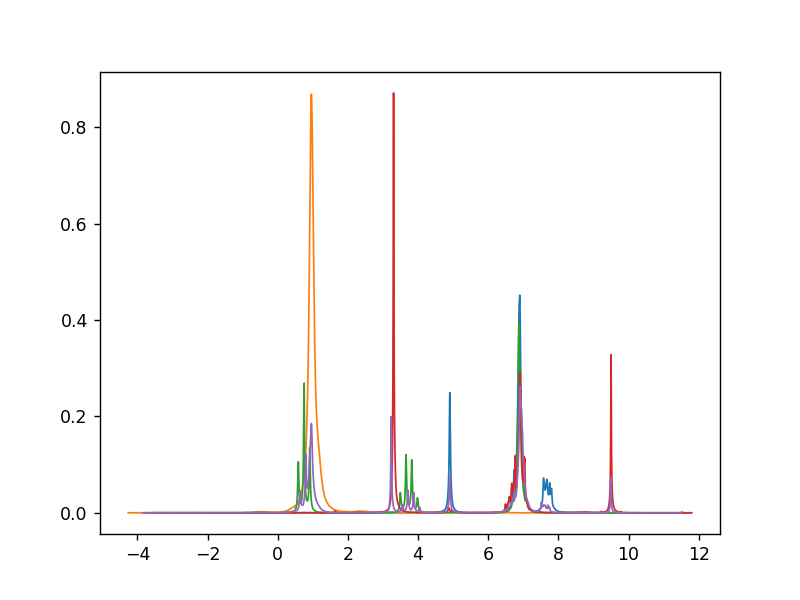

In [10]:
benzyl_benzoate.plot(profile=True)
cis_decahydronaftalene.plot(profile=True)
ethyl_phenyl_propiolate.plot(profile=True)
m_anisaldehyde.plot(profile=True)
mixture.plot(profile=True)

In [11]:
def shift(list_of_spectra, epsilon=0.001):
    res = list_of_spectra
    shifted_unique = []
    old_confs = [np.array(sp.confs) for sp in list_of_spectra]
    min_of_min = min([min(old_conf[:,0]) for old_conf in old_confs])
    if min_of_min<0:
        shift_coef = (min_of_min - epsilon)*(-1)
        for i, arr in enumerate(old_confs):
            new_ppm_non_unique = arr[:,0] + shift_coef
            resampled = res[i].resample(np.unique(new_ppm_non_unique) - shift_coef)
            new_ppm_unique = np.array(resampled.confs)[:,0]
            new_ints = np.array(resampled.confs)[:,1]
            res[i] = Spectrum(confs=list(zip(new_ppm_unique + shift_coef, new_ints)))
        return(res)
    else:
        return(list_of_spectra)

In [12]:
def make_nonnegative(spectrum):
    confs = np.array(spectrum.confs)
    neg = confs[:,1]<0
    confs[:,1][neg]=0
    new_confs = list(zip(confs[:,0],confs[:,1]))
    result = Spectrum(confs=new_confs)
    return(result)

In [13]:
# shifted_spectra = shift([isopropanol, creatine, mixture_iso_crea])
# isopropanol = shifted_spectra[0]
# creatine = shifted_spectra[1]
# mixture_iso_crea = shifted_spectra[2]

In [14]:
spectra = [benzyl_benzoate, cis_decahydronaftalene, ethyl_phenyl_propiolate, m_anisaldehyde, mixture]

In [15]:
shifted_spectra = shift(spectra)

In [16]:
preprocessed_spectra = []
for sp in shifted_spectra:
    sp2 = make_nonnegative(sp)
    sp2.sort_confs()
    sp2.merge_confs()
    sp2.normalize()
    preprocessed_spectra.append(sp2)

In [17]:
benzyl_benzoate = preprocessed_spectra[0]
cis_decahydronaftalene = preprocessed_spectra[1]
ethyl_phenyl_propiolate = preprocessed_spectra[2]
m_anisaldehyde = preprocessed_spectra[3]
mixture = preprocessed_spectra[4]

### Estimation

In [21]:
estimation = estimate_proportions(mixture, [benzyl_benzoate, cis_decahydronaftalene, ethyl_phenyl_propiolate, m_anisaldehyde], 
                                   MTD=0.3, MTD_th=0.3, verbose=True, solver=pulp.GUROBI())

Initial filtering of formulas: 100%|████████████| 4/4 [00:00<00:00, 1019.33it/s]


Removed theoretical spectra due to no matching experimental peaks: []
Envelope bounds: [(0.001000000000000334, 15.357410000000002, 1), (0.4210000000000007, 15.77741, 2), (0.6710000000000007, 16.02741, 0), (0.7110000000000007, 16.06741, 3)]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 169466.83it/s]


Number of chunks: 1
ChunkIDs: [0, 0, 0, 0]
Chunk bounds: [(-0.29899999999999965, 16.36741)]


Splitting the experimental spectrum into chunks: 8747it [00:00, 3493722.23it/s]


Ion currents in chunks: [0.9999999999999987]


Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]/home/basia/.local/lib/python3.10/site-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Deconvolving chunk 0
Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-10
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 139953 rows, 34991 columns and 309431 nonzeros
Model fingerprint: 0x21c9509a
Coefficient statistics:
  Matrix range     [4e-10, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-03, 2e-03]
  RHS range        [2e-04, 3e-01]
Presolve removed 45216 rows and 0 columns
Presolve time: 1.66s
Presolved: 34991 rows, 139952 columns, 309430 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 1.345e+05
 Factor NZ  : 7.682e+05 (roughly 80 MB of memory)
 Factor Ops : 1.899e+07 (less than 1 second p

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:10<00:00, 10.01s/it]


In [54]:
estimation = estimate_proportions2(mixture, [benzyl_benzoate, cis_decahydronaftalene, ethyl_phenyl_propiolate, m_anisaldehyde], MTD=0.3, MTD_th=0.3, verbose=True, noise='in_both_alg2')

Computing chunks: 100%|██████████| 4/4 [00:00<00:00, 22702.59it/s]
Splitting the experimental spectrum into chunks: 8747it [00:00, 884229.76it/s]
Deconvolving chunks:   0%|          | 0/1 [00:00<?, ?it/s]/home/basia/.local/lib/python3.6/site-packages/pulp/pulp.py:1199: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Removed theoretical spectra due to no matching experimental peaks: []
Envelope bounds: [(0.001000000000000334, 15.357410000000002, 1), (0.4210000000000007, 15.77741, 2), (0.6710000000000007, 16.02741, 0), (0.7110000000000007, 16.06741, 3)]
Number of chunks: 1
ChunkIDs: [0, 0, 0, 0]
Chunk bounds: [(-0.29899999999999965, 16.36741)]
Ion currents in chunks: [0.9999999999999991]
Deconvolving chunk 0


Deconvolving chunks: 100%|██████████| 1/1 [06:25<00:00, 385.17s/it]

Chunk %i deconvolution status: Optimal
Signal proportion in experimental spectrum: 0.98957562
Noise proportion in experimental spectrum: 0.010471836535
Total explanation: 1.000047456535
Noise proportion in combination of theoretical spectra: 0.0057992656


In [78]:
# print('Proportion estimated by masserstein:\n')
# print(str(estimation['proportions'])+'\n')
# print('Expected proportions:\n')
# print([0.2338, 0.2338, 0.3247, 0.2078])

In [23]:
estimation['proportions']

[0.2265874057309997,
 0.2331498272159997,
 0.31813118530299955,
 0.21170770608199974]

In [22]:
p = estimation['proportions']
p_sum = p[0]/12 + p[1]/18 + p[2]/10 + p[3]/8

In [24]:
estimated_proportions = [(p[0]/12)/p_sum, (p[1]/18)/p_sum, (p[2]/10)/p_sum, (p[3]/8)/p_sum]

In [25]:
print('Proportions estimated by masserstein:')
estimated_proportions

Proportions estimated by masserstein:


[0.20954324118668452,
 0.14374135320052678,
 0.3530411911953787,
 0.29367421441741]

In [1]:
print('True proportions:')
[0.75/3.5, 0.5/3.5, 1.25/3.5, 1/3.5]

True proportions:


[0.21428571428571427,
 0.14285714285714285,
 0.35714285714285715,
 0.2857142857142857]